In [1]:
from keras.utils import image_dataset_from_directory, set_random_seed
from keras.models import load_model
from collections import Counter
from pickle import load
from numpy import asarray
import matplotlib.pyplot as plt

In [2]:
set_random_seed(10)

In [3]:
img_size = (256, 256)
class_names = ['normal', 'pneumonia']
dataset_dir = '/Users/snoopy/Desktop/Other/Harvard/Final Project/RSNA/RSNA-full-jpeg'
color_mode = 'rgb'
num_channels = 3

In [4]:
train_data = image_dataset_from_directory(directory=dataset_dir+'/train',
                                          label_mode='binary',
                                          class_names=class_names,
                                          color_mode=color_mode,
                                          image_size=img_size,
                                          shuffle=True)
test_data = image_dataset_from_directory(directory=dataset_dir+'/test',
                                          label_mode='binary',
                                          class_names=class_names,
                                          color_mode=color_mode,
                                          image_size=img_size)
val_data = image_dataset_from_directory(directory=dataset_dir+'/val',
                                          label_mode='binary',
                                          class_names=class_names,
                                          color_mode=color_mode,
                                          image_size=img_size)

Found 16010 files belonging to 2 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 5338 files belonging to 2 classes.


2022-08-01 13:17:19.055891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-01 13:17:19.055987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 5336 files belonging to 2 classes.


In [5]:
model = load_model(filepath='/Users/snoopy/Desktop/Other/Harvard/Final Project/RSNA/RSNA-full-resnet-augmented/rsna-resnet-augmented')

In [6]:
with open('/Users/snoopy/Desktop/Other/Harvard/Final Project/RSNA/RSNA-full-resnet-augmented/rsna-resnet-augmented-history', 'rb') as f:
    history = load(f)

In [7]:
model.summary()

Model: "resnet_18_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['rescaling[0][0]']              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0

In [8]:
train_precision = asarray(history.history['precision'])
train_recall = asarray(history.history['recall'])
val_precision = asarray(history.history['val_precision'])
val_recall = asarray(history.history['val_recall'])
train_f1 = 2./(1./train_precision+1./train_recall)
val_f1 = 2./(1./val_precision+1./val_recall)

In [9]:
epochs = range(len(history.history['loss']))

In [10]:
print("Train precision: ", train_precision[-1])
print("Train recall: ", train_recall[-1])
print("Validation precision: ", val_precision[-1])
print("Validation recall: ", val_recall[-1])
print("F1 score in train set: ", train_f1[-1])
print("F1 score on validation set: ", val_f1[-1])

Train precision:  0.5429553389549255
Train recall:  0.8322705626487732
Validation precision:  0.5764476656913757
Validation recall:  0.7371047735214233
F1 score in train set:  0.6571803874813753
F1 score on validation set:  0.6469514476651348


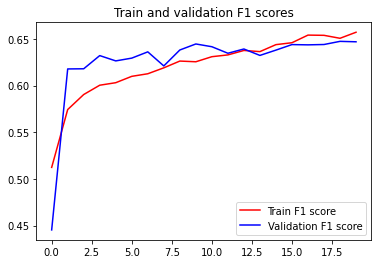

In [11]:
plt.figure()
plt.plot(epochs, train_f1, 'r', label='Train F1 score')
plt.plot(epochs, val_f1, 'b', label='Validation F1 score')
plt.title('Train and validation F1 scores')
plt.legend()
plt.show()

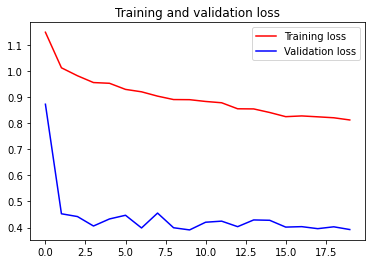

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

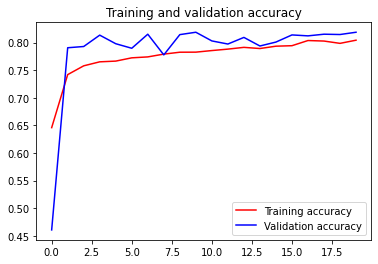

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

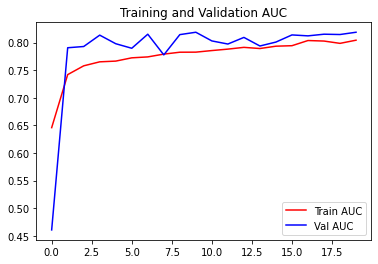

In [15]:
auc = history.history['auc']
val_auc = history.history['val_auc']
plt.figure()
plt.plot(epochs, acc, 'r', label='Train AUC')
plt.plot(epochs, val_acc, 'b', label='Val AUC')
plt.title('Training and Validation AUC')
plt.legend()
plt.show()

In [22]:
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, Precision, Recall, AUC

In [30]:
threshold = 0.5

In [32]:
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(name='accuracy', threshold=threshold),
                       Precision(thresholds=threshold, name='precision'),
                       Recall(thresholds=threshold, name='recall'),
                       AUC(name='auc')])

In [14]:
train_res = model.evaluate(train_data, verbose=1)
val_res = model.evaluate(val_data, verbose=1)
test_res = model.evaluate(test_data, verbose=1)

2022-08-01 13:18:10.477200: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-01 13:18:10.477611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 26s 151ms/step - loss: 0.4056 - accuracy: 0.8061 - precision: 0.5536 - recall: 0.7207 - auc: 0.8682


In [16]:
train_pred = model.predict(train_data, verbose=1)
val_pred = model.predict(val_data, verbose=1)
test_pred = model.predict(test_data, verbose=1)

2022-08-01 13:20:49.639147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 24s 141ms/step


In [17]:
train_pred_labels = []
for pred in train_pred:
    if pred>threshold:
        train_pred_labels.append(1)
    else:
        train_pred_labels.append(0)

val_pred_labels = []
for pred in val_pred:
    if pred>threshold:
        val_pred_labels.append(1)
    else:
        val_pred_labels.append(0)

test_pred_labels = []
for pred in test_pred:
    if pred>threshold:
        test_pred_labels.append(1)
    else:
        test_pred_labels.append(0)

print("Training predictions")
print(Counter(train_pred_labels))
print("\nValidation predictions")
print(Counter(val_pred_labels))
print('\nTest predictions')
print(Counter(test_pred_labels))

Training predictions
Counter({0: 11406, 1: 4604})

Validation predictions
Counter({0: 3808, 1: 1528})

Test predictions
Counter({0: 3772, 1: 1566})


In [ ]:
"""{'train':{'normal': 12403, 'pneumonia': 3607},
'test':{'normal': 4135, 'pneumonia': 1203},
'val':{'normal': 4134, 'pneumonia': 1202}}"""

In [18]:
train_f1_from_eval = 2./(1./train_res[2]+1./train_res[3])
val_f1_from_eval = 2./(1./val_res[2]+1./val_res[3])
test_f1 = 2./(1./test_res[2]+1./test_res[3])

In [19]:
print('Train precision: ', train_res[2])
print("Train recall: ", train_res[3])
print("Train F1: ", train_f1_from_eval)
print("\nValidation precision: ", val_res[2])
print("Validation recall: ", val_res[3])
print("Validation F1: ", val_f1_from_eval)
print("\nTest precision: ", test_res[2])
print("Test recall: ", test_res[3])
print("Test F1: ", test_f1)

Train precision:  0.5892702341079712
Train recall:  0.7521485686302185
Train F1:  0.6608208595495723

Validation precision:  0.5765706896781921
Validation recall:  0.7329450845718384
Validation F1:  0.6454212483997741

Test precision:  0.5536398887634277
Test recall:  0.7206982970237732
Test F1:  0.626218894554672
